In [2]:
import pandas as pd
from build_db import create_conn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
conn = create_conn("bgg_history.db")
df = pd.read_sql_query("SELECT * FROM top_100_history", conn)

df['rank_year'] = df.rank_year.astype(str)
df['rank_month'] = df.rank_month.astype(str)
df['date_str'] = df.rank_year + '-' + df.rank_month
df['date'] = pd.to_datetime(df['date_str'])

In [4]:
df.dtypes

id                        int64
name                     object
year                      int64
rank                      int64
average                 float64
bayes_average           float64
users_rated               int64
url                      object
thumbnail                object
rank_year                object
rank_month               object
date_str                 object
date             datetime64[ns]
dtype: object

In [5]:
features = ['id', 'date', 'average', 'bayes_average', 'users_rated', 'name', 'rank']
data = df[df['rank'] <= 100].copy()
data = data[features]
data.nunique()

id                153
date               59
average           157
bayes_average     936
users_rated      5500
name              164
rank              100
dtype: int64

In [6]:
# there are clearly games with multiple names. Let's standadize it

dups = data.groupby(['id', 'name']).count()
ids_names = dups.reset_index()[['id', 'name']]
dups = ids_names.groupby('id').count()
dups = dups[dups.name > 1].index.to_list()
dups_names = ids_names[ids_names.id.isin(dups)]
dups_names_dict = dups_names.drop_duplicates(subset=['id'], keep='last').set_index('id').to_dict()['name']
dups_names_dict


{2511: 'Sherlock Holmes Consulting Detective: The Thames Murders & Other Cases',
 9609: 'War of the Ring (first edition)',
 12493: 'Twilight Imperium: Third Edition',
 28720: 'Brass: Lancashire',
 37111: 'Battlestar Galactica: The Board Game',
 115746: 'War of the Ring: Second Edition',
 198928: 'Pandemic: Iberia',
 233078: 'Twilight Imperium: Fourth Edition',
 256960: 'Pax Pamir: Second Edition',
 269385: 'The Lord of the Rings: Journeys in Middle-earth'}

In [7]:
uniques = data.nunique()

for id in dups:
    data.loc[data.id == id, 'name'] = dups_names_dict[id]

# check if names are now corrected
data.nunique()

id                153
date               59
average           157
bayes_average     936
users_rated      5500
name              153
rank              100
dtype: int64

<AxesSubplot:xlabel='date', ylabel='rank'>

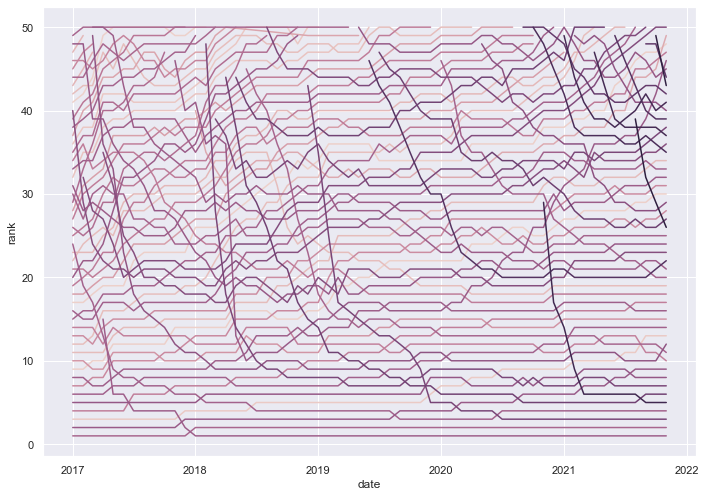

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
reduced_data = data[data['rank'] <= 50]
sns.lineplot(data=reduced_data, x='date', y='rank', hue='id', legend=False)

what a freaking mess, lets reduce our dataset and focus on one game at a time

In [9]:
#lets get only the ones that never left the top100

weeks_on_top_100 = data.groupby('id').count().name
max_weeks = weeks_on_top_100.max()
stayed_most_on_top100 = weeks_on_top_100[weeks_on_top_100 == max_weeks].index.to_list()
len(stayed_most_on_top100)

55

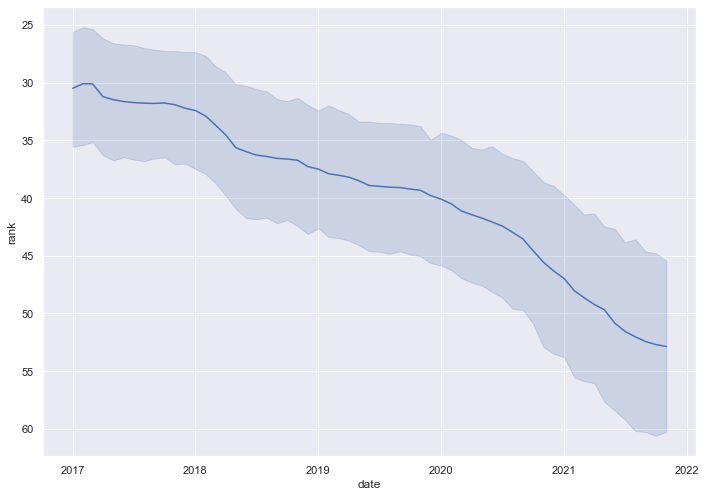

In [10]:
reduced_data = data[data.id.isin(stayed_most_on_top100)]
reduced_data = reduced_data.sort_values(by=['id', 'date'])
reduced_data['diff'] = reduced_data.groupby('id')['rank'].diff()

ids = reduced_data.id.unique()
id_to_game_name = {id:reduced_data[reduced_data.id == id].name.iloc[0] for id in ids}

# here it is clear that the tendency of a game is to decrease over time. New is always better?
ax = sns.lineplot(data=reduced_data, x='date', y='rank', legend=False)
ax.invert_yaxis()

In [11]:
dates = data['date'].drop_duplicates().reset_index()['date'].to_frame().reset_index()
dates.columns = ['number', 'date']

for date in dates.date:
    month_number = dates[dates.date==date].number.iloc[0]
    data.loc[data.date == date, 'month_number'] = month_number

# forecasting

## Using RNNs to preview the movement of the games in the top 100

https://unit8co.github.io/darts/examples/05-RNN-examples.html

In [12]:
from darts import TimeSeries

series_list = []
for id in ids:
    df = reduced_data[reduced_data.id == id].copy()
    s = TimeSeries.from_dataframe(df, 'date', 'rank')
    series_list.append(s)


In [28]:
from darts.models import RNNModel

model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=8,
    n_epochs=1000,
    optimizer_kwargs={'lr': 1e-3},
    model_name='bgg_top100_RNN',
    log_tensorboard=False,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True    
)

model.fit(series_list)

[2021-11-19 16:35:10,239] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2145 samples.
[2021-11-19 16:35:10,239] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2145 samples.
[2021-11-19 16:35:10,241] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-11-19 16:35:10,241] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


El Grande


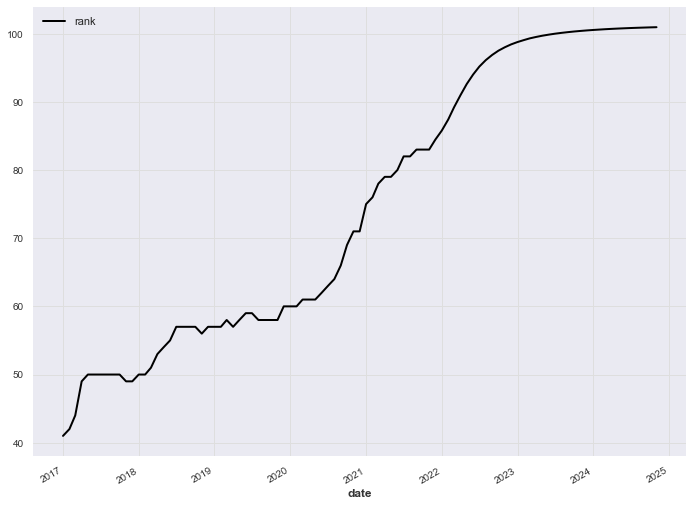

In [27]:
idx = 1 #getting the index of the game in our 55 games list
n=36 #predicting the game's position for the next 36 months
print(id_to_game_name[ids[idx]])
series = series_list[idx]
future = model.predict(n=n, series=series)


series.append(future).plot()

## Predicting when a game will leave top 100 using bayesian inference

https://towardsdatascience.com/probabilistic-programming-and-bayesian-inference-for-time-series-analysis-and-forecasting-b5eb22114275

50    Tigris & Euphrates
Name: name, dtype: object


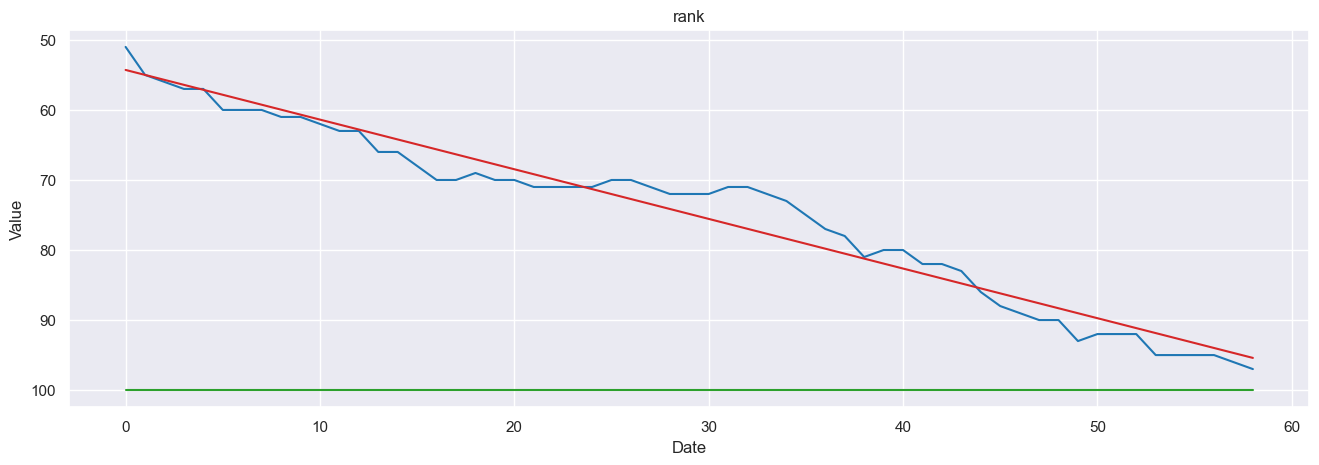

In [93]:
import numpy as np
from sklearn.linear_model import LinearRegression

idx = 0

regression_data = data[data.id == stayed_most_on_top100[idx]]
print(data[data.id == stayed_most_on_top100[idx]].head(1).name)

X1 = regression_data.month_number.values
Y1 = regression_data['rank'].values
X = X1.reshape(-1, 1)
Y = Y1.reshape(-1, 1)
reg = LinearRegression().fit(X, Y)
beta, alpha = reg.coef_, reg.intercept_

Y_reg = beta * X1 + alpha

def plot_df(x, y, y_reg, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.plot(x, y_reg, color='tab:red')
    plt.plot(x, [100]*len(x), color='tab:green')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.show()

plot_df(x=X1, y=Y1, y_reg=Y_reg[0], title='rank')

In [94]:

import pymc3 as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=int(beta), sd=10)
    alpha = pm.Normal("alpha", mu=int(alpha), sd=10)
    
    mean = pm.Deterministic("mean", alpha + beta * X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]

/tmp/ipykernel_24320/101159671.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(100000, step=pm.Metropolis())
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [std]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 51 seconds.
The number of effective samples is smaller than 10% for some parameters.


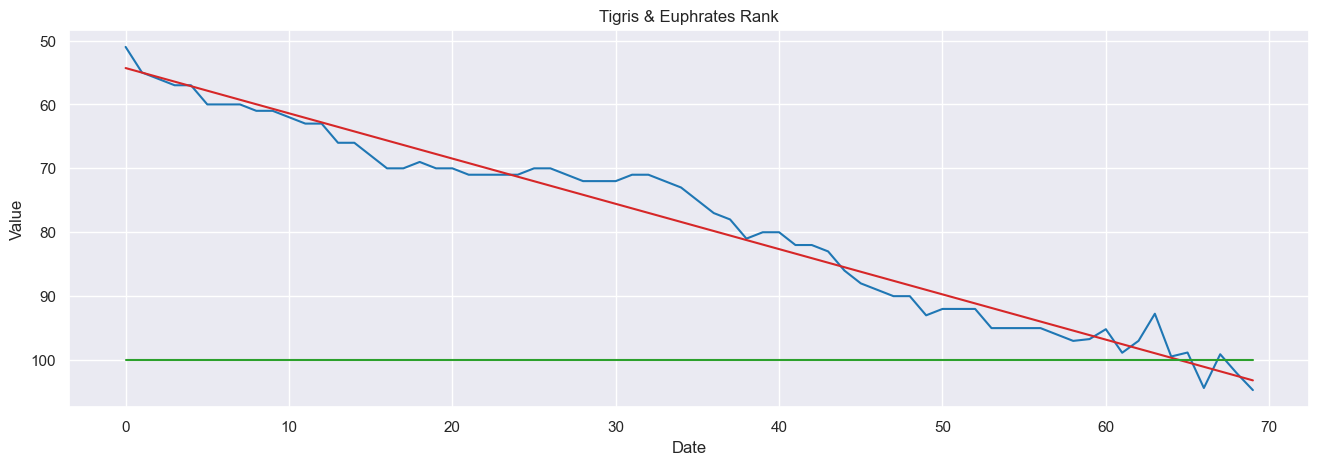

In [95]:
std_trace = burned_trace['std']
beta_trace = burned_trace['beta']
alpha_trace = burned_trace['alpha']
std_mean = std_trace.mean()
beta_mean = beta_trace.mean()
alpha_mean = alpha_trace.mean()
length = 70
x1 = np.arange(length)
mean_trace = alpha_mean + beta_mean * x1
normal_dist = pm.Normal.dist(0, sd=std_mean)
errors = normal_dist.random(size=length)
Y_gen = mean_trace + errors
Y_gen = np.concatenate((Y1, Y_gen[59:]))
Y_reg1 = mean_trace
plot_df(x=x1, y=Y_gen, y_reg=Y_reg1, title='Tigris & Euphrates Rank')

In [96]:
n = 100000
gt_100 = {}
for _ in tqdm(range(n)):
    std_mean = std_trace.mean()
    beta_mean = beta_trace.mean()
    alpha_mean = alpha_trace.mean()
    length = 70
    x1 = np.arange(length)
    mean_trace = alpha_mean + beta_mean * x1
    normal_dist = pm.Normal.dist(0, sd=std_mean)
    errors = normal_dist.random(size=length)
    Y_gen = mean_trace + errors
    Y_gen = np.concatenate((Y1, Y_gen[59:]))
    try:
        first_gt_100 = np.argwhere(Y_gen > 100)[0][0]
    except:
        continue
    if not first_gt_100 in gt_100:
        gt_100[first_gt_100] = 0
    gt_100[first_gt_100] += 1

100%|██████████| 100000/100000 [02:53<00:00, 577.91it/s]


7 months - 91.44%


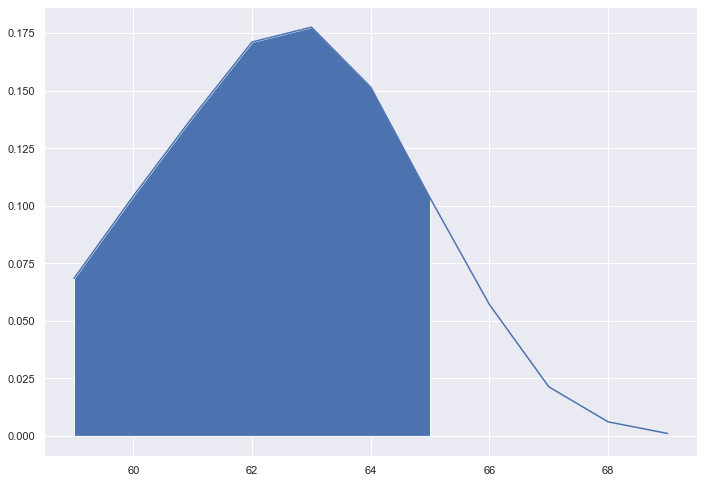

In [97]:
probs = [(k,(gt_100[k]/n)) for k in gt_100]
probs.sort(key=lambda x: x[0])
x = [x[0] for x in probs]
y = [x[1] for x in probs]


idx = 7

print(f'{x[idx]-len(Y1)} months - {sum(y[:idx])*100:.2f}%')

plt.fill_between(x[:idx],y[:idx])
plt.legend = f'{x[idx]-len(Y1)} months - {sum(y[:idx])*100:.2f}%'
plt.plot(x, y)
plt.show()